# Определение возраста покупателей магазина по фотографиям

## Описание проекта

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

### Цель проекта

Построить модель, которая по фотографии определит приблизительный возраст человека.

Требования: 
- Значение метрики *MAE* (Mean Absolute Error — средняя абсолютная ошибка) на тестовой выборке должно быть не больше 8. В статье об используемом датасете значение *MAE* равно 5.4. Значение *MAE* меньше 7 будет отличным результатом.

### Задачи проекта

1. Провести исследовательский анализ набора фотографий.

2. Подготовить данные к обучению.

3. Обучить нейронную сеть и оценить её качество.

### Описание данных

Датасет для обучения и проверки качества модели — APPA-REAL (real and apparent age) с сайта [ChaLearn Looking at People](https://chalearnlap.cvc.uab.es/dataset/26/description/). 

Данные на сервере находятся в каталоге `/datasets/faces/`. 
- Все изображения находятся в подкаталоге `/final_files`. 
- CSV-файл `labels.csv` содержит две колонки: 
    - `file_name` — имя файла с фотографией человека,
    - `real_age` — возраст человека на фото (целевой признак).

### Импорты

In [1]:
import os
import random

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from PIL import Image
from scipy import stats as st

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error

### Настройки

In [2]:
# фиксируем случайное состояние
RANDOM_STATE = 12345

### Пользовательские функции

In [3]:
def get_image_info(file: str) -> dict:
    """
    Возвращает словарь, содержащий свойства изображения:
    format - формат файла,
    mode - формат пикселя, например "L" для ч/б и "RGB" для цветного,
    size - размер (ширина, высота).
    """
    with Image.open(file) as img:
        result = {}
        result['format'] = img.format
        result['mode'] = img.mode
        result['size'] = img.size
    return result

In [4]:
def image_grid(images, target=None, target_name=''):
    """
    Выводит изображения в виде сетки
    с указанием значения целевого признака.
    """
    # количество изображений
    n = len(images)
    
    # если не задан массив значений целевого признака
    if target is None:
        target = ['' for i in range(n)]
        
    # находим наибольший делитель числа, который ближе всего к его корню
    ncols = max([m for m in range(1, int(np.ceil(np.sqrt(n)))+2) if n // m])
    nrows = n // ncols
    
    # создаём область построения
    fig = plt.figure(figsize=(12, round(12*nrows/ncols)))
    
    for i in range(n):
        fig.add_subplot(nrows, ncols, i+1)
        
        # выводим изображение
        plt.imshow(images[i])
        
        # подпись - значение целевого признака
        plt.title(f'{target_name}: {target[i]}')
        
        # для компактности удаляем оси и прижимаем изображения друг к другу
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()

In [5]:
def process_train_output(text):
    """
    Преобразует текстовый вывод обучения модели в датафрейм
    с полями:
    - train_loss - функция потерь на обучающей выборке,
    - train_metric - функция потерь на тестовой выборке,
    - val_loss - метрика на обучающей выборке,
    - val_metric - метрика на тестовой выборке,
    индекс - номер эпохи (начинается с 1).
    """
    df = pd.DataFrame([x.split() for x in text.split('\n')])
    df = df.loc[df[12] == '-', 5::3]
    df = df.astype('float')
    
    df.index = pd.Index(range(1, len(df)+1), name='epoch')
    df.columns = ['train_loss', 'train_metric', 'val_loss', 'val_metric']
    
    return df

In [6]:
def best_epoch_result(df, patience=5):
    """
    Возвращает датафрейм из одной строки
    с показателями "лучшей" эпохи.
    """
    best_epoch = len(df) - patience
    best_result = df.loc[best_epoch, :]
    
    return best_result.to_frame().T

In [7]:
def plot_train_results(df_list):
    """
    Строит графики изменения функции потерь и метрики, заданной в модели,
    в ходе её обучения.
    """
    # создаём область построения 
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
    
    # цвета для графиков
    color = plt.cm.tab10([0,1])
    
    for df in df_list:
        # показатели лучшей эпохи
        best = best_epoch_result(df)
        
        # график изменения функции потерь 
        df[['train_loss', 'val_loss']].plot(ax=axes[0], color=color)
        best[['train_loss', 'val_loss']].plot(ax=axes[0], marker='o', color=color)
        
        # график изменения функции метрики
        df[['train_metric', 'val_metric']].plot(ax=axes[1], color=color)
        best[['train_metric', 'val_metric']].plot(ax=axes[1], marker='o', color=color)

    # список эпох
    epochs = range(2, max([len(df) for df in df_list])+1, 2)
    
    # оформляем графики
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Функция потерь - MSE')
    axes[1].set_ylabel('MAE')
    axes[1].set_title('Метрика MAE')
    for ax in axes:
        ax.set_xlabel('Эпоха')
        ax.set_xlim(0, max(epochs)+1)
        ax.set_xticks(epochs)
        ax.legend(['train', 'test'])
        ax.grid()
    fig.suptitle('Показатели модели в ходе обучения')
    
    return fig, axes

## Исследовательский анализ данных

### Проверка данных

In [8]:
# путь к данным на сервере
data_path = '/datasets/faces/'

# каталог с изображениями
image_path = data_path + 'final_files/'

Подсчитаем количество изображений в каталоге и проверим, что это число совпадает с количеством записей в таблице `labels.csv`, содержащей значения целевого признака.

In [9]:
# считаем количество файлов в каталоге
num_files = len(next(os.walk(image_path))[2])

print(f'Количество файлов в каталоге {image_path}: {num_files}')

Количество файлов в каталоге /datasets/faces/final_files/: 7591


In [10]:
# загружаем данные из CSV-файла
labels_df = pd.read_csv(data_path + 'labels.csv')

In [11]:
# общая информация о данных
labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [12]:
print('Количество записей в таблице совпадает с количеством изображений в каталоге:', 
      num_files == len(labels_df))

Количество записей в таблице совпадает с количеством изображений в каталоге: True


Количество записей в таблице совпадает с количеством изображений в каталоге, а также соответствует информации из описания датасета: "The APPA-REAL database contains 7,591 images".

In [13]:
# первые строки таблицы
labels_df.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


- В таблице имена файлов указаны в относительном формате, без пути. 

- Возраст выражен целым числом лет (тип данных `int64`).

Проверим, что все указанные в таблице файлы действительно существуют.

In [14]:
%%time
# проверяем существование всех файлов, указанных в столбце 'file_name'
print('Все указанные в таблице файлы существуют:',
      labels_df['file_name'].apply(
          lambda x: os.path.isfile(image_path + x))
      .all())

Все указанные в таблице файлы существуют: True
CPU times: user 575 ms, sys: 467 ms, total: 1.04 s
Wall time: 1min 29s


Проверим, нет ли в таблице дубликатов — записей с одинаковым именем файла.

In [15]:
print('Количество дубликатов:',
      labels_df.duplicated(subset=['file_name']).sum())

Количество дубликатов: 0


### Анализ целевого признака

Исследуем распределение людей на фотографиях по возрасту.

In [16]:
# статистические характеристики распределения
labels_df[['real_age']].describe().T

,count,mean,std,min,25%,50%,75%,max
real_age,7591.0,31.201159,17.14506,1.0,20.0,29.0,41.0,100.0


Построим гистограмму распределения.

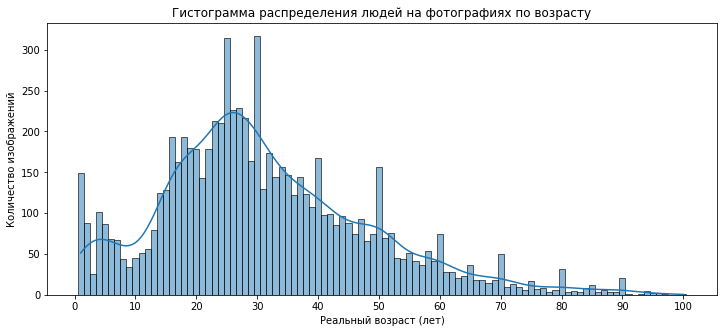

In [17]:
# создаём область построения графиков
plt.figure(figsize=(12, 5))

# строим график
ax = sns.histplot(labels_df['real_age'], discrete=True, kde=True)

plt.xticks(range(0, 101, 10))
plt.xlabel('Реальный возраст (лет)')
plt.ylabel('Количество изображений')
plt.title('Гистограмма распределения людей на фотографиях по возрасту');

Анализ распределения людей на фотографиях в датасете по возрасту показывает: 
- Нет сильного преобладания какой-то возрастной группы.
- Диапазон возраста людей на фотографиях: от 1 до 100 лет.
- В датасете преобладают фотографии людей молодого и среднего возраста. 50% людей на фото имеет возраст от 20 до 41 года. Средний возраст людей на фото — 31 год, медианный — 29 лет. 
- Также довольно значительно количество фотографий маленьких детей младше 8 лет.
- Фотографий пожилых людей старше 60 лет мало.
- Фотографий детей в возрасте от 8 до 12 лет меньше, чем можно было ожидать исходя из типичного вида возрастной пирамиды.
- В распределении заметны пики на значениях возраста 25 лет и кратных 10, начиная с 30 лет (30, 40, 50 и т.д. до 90).

### Анализ изображений

Исследуем свойства изображений в датасете:
- формат файлов изображений,
- цветность изображений (формат пикселя),
- размеры изображений.

Для этого получим сведения об указанных в датафрейме изображениях с помощью библиотеки `PIL`. Используем пользовательскую функцию `get_image_info()`.

In [18]:
%%time
# применяем функцию 'get_image_info' к датафрейму
labels_df[['image_format', 'image_mode', 'image_size']] = labels_df.apply(
    lambda x: get_image_info(image_path + x['file_name']), 
    axis=1, result_type='expand')

# извлекаем из размера дополнительные признаки:
# ширина, высота и соотношение сторон (аспект)
labels_df['image_width'] = labels_df['image_size'].apply(lambda x: x[0])
labels_df['image_height'] = labels_df['image_size'].apply(lambda x: x[1])
labels_df['image_aspect'] = labels_df['image_width'] / labels_df['image_height']

labels_df.head()

CPU times: user 3.31 s, sys: 1.23 s, total: 4.54 s
Wall time: 1min 33s


,file_name,real_age,image_format,image_mode,image_size,image_width,image_height,image_aspect
0,000000.jpg,4,JPEG,RGB,"(114, 114)",114,114,1.0
1,000001.jpg,18,JPEG,RGB,"(784, 784)",784,784,1.0
2,000002.jpg,80,JPEG,RGB,"(133, 133)",133,133,1.0
3,000003.jpg,50,JPEG,RGB,"(370, 370)",370,370,1.0
4,000004.jpg,17,JPEG,RGB,"(212, 212)",212,212,1.0


Посчитаем количество уникальных значений полученных признаков — свойств изображения.

In [19]:
(labels_df[
    [
     'image_format', 
     'image_mode', 
     'image_size', 
     'image_width', 
     'image_height', 
     'image_aspect',
    ]
].nunique()
 .rename('количество уникальных значений')
 .to_frame()
)

,количество уникальных значений
image_format,1
image_mode,1
image_size,2293
image_width,1195
image_height,1204
image_aspect,1193


Получается, что все изображения в датасете имеют формат JPEG и представлены в цветовой модели RGB, но не все имеют одинаковый размер.

Исследуем распределение изображений по размеру.

In [20]:
# статистические характеристики распределения
labels_df[['image_width', 'image_height', 'image_aspect']].describe().T

,count,mean,std,min,25%,50%,75%,max
image_width,7591.0,464.733764,330.834794,47.000000,220.0,385.0,632.0,4466.000000
image_height,7591.0,464.093927,331.289883,47.000000,220.0,384.0,632.0,4466.000000
image_aspect,7591.0,1.002926,0.070334,0.466276,1.0,1.0,1.0,2.985075


Половина всех изображений имеет размеры от 220 до 632 пикселей, при этом в датасете есть маленькие (47 пикселей) и очень большие (более 4000 пикселей) изображения.

Преобладающее соотношение сторон — 1, т.е. большинство изображений — квадратные.

Построим распределение изображений по соотношению сторон.

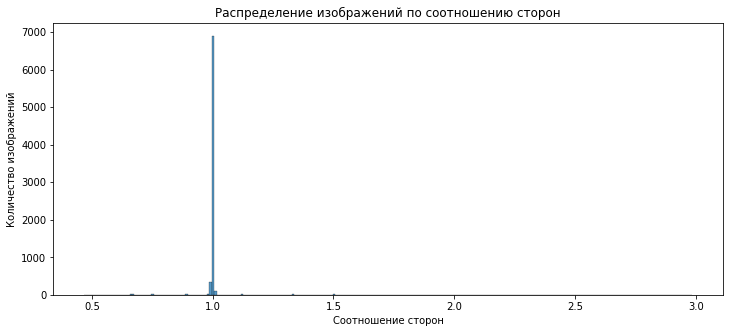

In [21]:
# создаём область построения
plt.figure(figsize=(12, 5))

# строим гистограмму
sns.histplot(labels_df['image_aspect'], binwidth=0.01)

# оформляем график
plt.xlabel('Соотношение сторон')
plt.ylabel('Количество изображений')
plt.title('Распределение изображений по соотношению сторон');

Подавляющее большинство изображений — квадратные (соотношение сторон 1).

Построим диаграмму рассеяния, которая покажет распределение изображений по размерам.

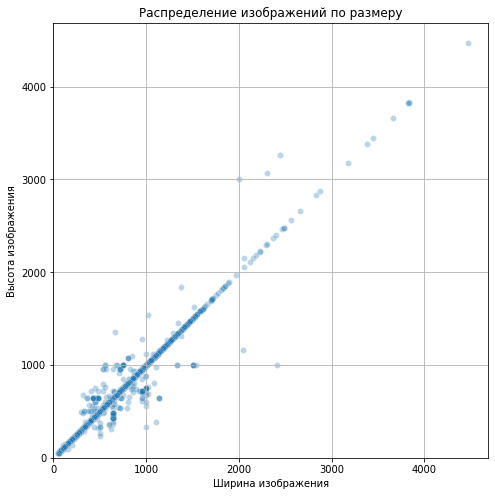

In [22]:
# создаём область построения
plt.figure(figsize=(8, 8))

# строим диаграмму рассеяния
ax = sns.scatterplot(x=labels_df['image_width'], 
                     y=labels_df['image_height'],
                     alpha=0.3)
# оформляем график
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.grid()
ax.set_aspect('equal')
plt.xlabel('Ширина изображения')
plt.ylabel('Высота изображения')
plt.title('Распределение изображений по размеру');

Видно, что все изображения сосредоточены вблизи диагональной прямой "ширина = высота", а неквадратных изображений очень мало.

Теперь рассмотрим распределение изображений отдельно по ширине и высоте.

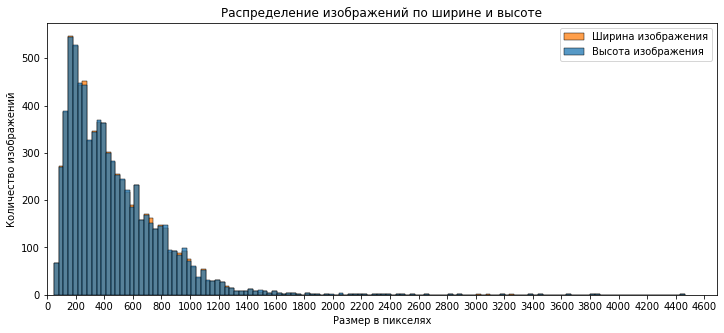

In [23]:
# создаём область построения
plt.figure(figsize=(12, 5))

# строим гистограмму
sns.histplot(labels_df[['image_width', 'image_height']])

# оформляем график
plt.legend(['Ширина изображения', 'Высота изображения'])
plt.xlim(left=0)
plt.xticks(range(0, 4700, 200))
plt.xlabel('Размер в пикселях')
plt.ylabel('Количество изображений')
plt.title('Распределение изображений по ширине и высоте');

Распределения по ширине и высоте практически идентичны, как и следовало ожидать при доминировании квадратных изображений.

Изображений большого размера (более 1600 пикселей) крайне мало.

In [24]:
# находим самые частые размеры изображения
(labels_df['image_size']
 .value_counts()
 .head(10)
 .reset_index()
 .rename(columns={
     'index': 'image_size', 
     'image_size': 'количество',
 })
)

,image_size,количество
0,"(517, 517)",37
1,"(165, 165)",37
2,"(166, 166)",31
3,"(331, 331)",28
4,"(257, 257)",27
5,"(434, 434)",27
6,"(184, 184)",24
7,"(190, 190)",23
8,"(355, 355)",22
9,"(251, 251)",22


Наиболее часто встречаются изображения размером 517×517 и 165×165 пикселей, но явного преобладания какого-либо одного размера нет.

Посмотрим на несколько случайно выбранных изображений из датасета. Использовать для такой задачи `ImageDataGenerator` — это перебор, лучше создадим случайную выборку средствами библиотеки Pandas.

Для вывода изображений в виде сетки с указанием значения целевого признака применим пользовательскую функцию `image_grid()`.

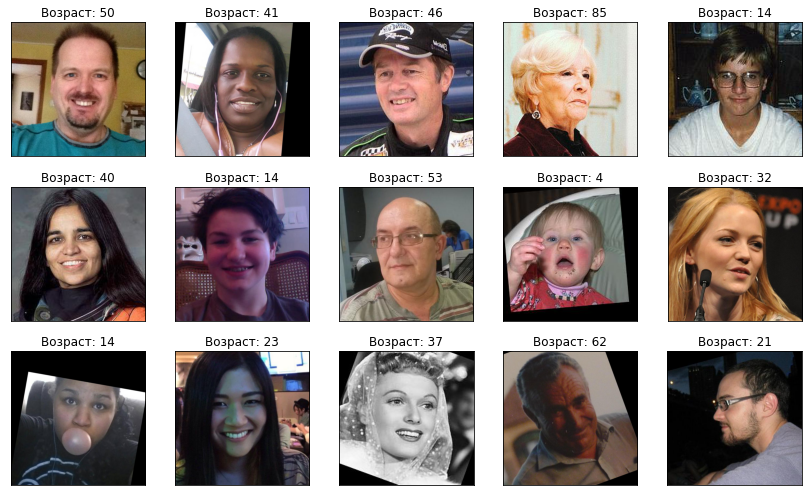

In [25]:
# случайная выборка из данных
random_sample = labels_df.sample(n=15, random_state=RANDOM_STATE)

# список изображений
sample_images = [Image.open(image_path + f) for f in random_sample['file_name']]

# массив значений целевого признака
sample_target = random_sample['real_age'].values

# выводим изображения
image_grid(sample_images, sample_target, target_name='Возраст')

# освобождаем память - удаляем переменную с выборкой изображений
del sample_images

Даже по такой небольшой выборке можно заключить:
- В датасете представлены фотографии людей различных рас и национальностей.
- Люди на фотографиях как правило смотрят в камеру или под небольшим углом от неё, но попадаются и фото в профиль. 
- Фотографии явно получены из разных открытых источников: условия съёмки (фон и освещение) сильно отличаются, на некоторых можно узнать известных личностей.
- Лица людей на фотографиях целиком попадают в кадр. При этом нет сильных вариаций размера лица в кадре. 
- Все изображения центрированы таким образом, что нос человека находится примерно в центре изображения. При этом некоторые изображения повёрнуты и сдвинуты с заполнением пустот чёрным цветом.
- Попадаются чёрно-белые изображения (т.е. у них все три цветовых канала одинаковы).

### Выводы

Результаты исследовательского анализа данных таковы:

1. В датасете 7591 изображение. Размер датасета относительно небольшой по сравнению с популярными CIFAR и ImageNet, но достаточный для обучения модели. На большом датасете модель обучалась бы очень долго.
    - Количество изображений в каталоге `final_files/` совпадает с количеством записей в таблице `labels.csv`, содержащей значения целевого признака.
    - Пропуски и дубликаты записей в таблице отсутствуют.
    - Все указанные в таблице файлы существуют.
    
2. Вид распределения людей на фотографиях в датасете по возрасту в целом адекватный. В идеале выборка для обучения модели должна быть стратифицирована, т.е. иметь распределение по целевому признаку (возрасту) и по признакам, влияющим на внешность человека (пол, раса, национальность) такое же, как у населения местности, в которой предполагается применять модель. Но предоставленный датасет размечен только по возрасту.
    - Диапазон возраста людей на фотографиях: от 1 до 100 лет. Преобладают люди молодого и среднего возраста: половина людей на фото имеет возраст от 20 до 41 года. Средний возраст людей на фото — 31 год, медианный — 29 лет. 
    - Нет сильного преобладания какой-то одной возрастной группы. Распределение людей по возрасту в датасете в принципе верно отражает распределение людей по возрасту в популяции, за исключением двух моментов:
        - Детей в возрасте от 8 до 12 лет меньше, чем можно было ожидать исходя из типичного вида возрастной пирамиды;
        - Пики в распределении на значениях возраста 25 лет и кратных 10, начиная с 30 лет (30, 40, 50 и т.д. до 90). 
      Видимо, эти особенности — следствие использованной процедуры сбора данных при составлении датасета.
      
    Поэтому можно ожидать, что модель для определения возраста по фото покажет наибольшую точность для тех значений возраста, которые больше всего представлены в обучающей выборке. Это диапазон возраста от 20 до 40 лет, особенно для значений 25 и 30 лет. Следует ожидать пониженной точности для людей старше 60 лет и для детей 8-12 лет.
    
    Вряд ли для обучения модели, которая должна определять возраст покупателей в магазине, будут полезны фотографии младенцев и детей дошкольного возраста, поэтому их можно было бы и не учитывать, но для сравнения качества модели с референсным значением следует использовать полный датасет.
    
3. Все изображения в датасете имеют формат JPEG и представлены в цветовой модели RGB, но не все имеют одинаковый размер.
    - Подавляющее большинство изображений — квадратные. Максимальное значение соотношения сторон ≈3.
    - Половина всех изображений имеет размеры от 220 до 632 пикселей, при этом в датасете есть маленькие (47 пикселей) и очень большие (более 4000 пикселей) изображения. Изображений большого размера (более 1600 пикселей) крайне мало. Явного преобладания какого-либо одного размера нет, распределение довольно широкое.
    
4. В датасете представлены фотографии людей различных рас и национальностей, явно полученные из разных открытых источников: условия съёмки (фон и освещение) сильно отличаются, на некоторых можно узнать известных личностей.
    - Люди на фотографиях как правило смотрят в камеру или под небольшим углом от неё, но попадаются и фото в профиль.
    - Лица людей на фотографиях целиком попадают в кадр. При этом нет сильных вариаций размера лица в кадре. 
    - Все изображения центрированы таким образом, что нос человека находится примерно в центре изображения. При этом некоторые изображения повёрнуты и сдвинуты с заполнением пустот чёрным цветом.
    - Попадаются чёрно-белые изображения (т.е. у них все три цветовых канала одинаковы).
    
   Качество исходных данных для обучения ML модели в значительной степени определяет качество её предсказаний. В целом качество изображений в датасете приемлемое. Видно, что была проведена обработка: кроп, масштабирование, повороты, центрирование лица. Это позволяет надеяться на хороший результат обучения ML модели. Но при подготовке данных для обучения и проверки качества модели нужно учитывать выявленные особенности датасета:
    - Изображения нужно привести к одному размеру.
    - Поскольку все изображения уже центрированы и масштабированы, и в датасете встречаются повёрнутые изображения, то из дополнительных аугментаций достаточно добавить только отражение по горизонтали.

## Обучение модели

### Обучение модели на GPU

Определение по фотографии возраста человека — это **задача регрессии**.

Обучение модели выполнено на сервере с GPU. Построена свёрточная нейронная сеть и обучена на обучающей выборке из датасета. Для обучения модели на сервере с GPU подготовлен код в файле с расширением ".py", включающий следующие функции:
- `load_train(path)` для загрузки обучающей выборки,
- `load_test(path)` для загрузки тестовой выборки,
- `create_model(input_shape)` для создания модели,
- `train_model(model, train_data, test_data, batch_size, epochs, steps_per_epoch, validation_steps)` для обучения модели.

1. В функциях `load_train()` и `load_test()` для загрузки изображений из датасета использован метод `flow_from_dataframe()` загрузчика данных `ImageDataGenerator`, создающий генератор, который формирует батчи по 32 изображения с метками классов.
    - Все изображения приведены к одному размеру: 224×224 пикселей, как в датасете ImageNet, на котором была предобучена модель `ResNet50`, и нормализованы — значения пикселей приведены к диапазону \[0, 1\].
    - Для масштабирования изображений использован метод билинейной интерполяции: `interpolation='bilinear'`.
    - Датасет разделён на обучающую и тестовую выборки в пропорции 3:1 (т.е. доля тестовой выборки 0.25).
    - Чтобы обучающая и тестовая выборки не пересекались, в обеих функциях использовано одинаковое число, задающее случайное состояние: `seed=RANDOM_STATE`.
    - К обучающей выборе применены аугментации — отражение по горизонтали: `horizontal_flip=True`.

2. В функции `create_model()` построена свёрточная нейронная сеть на базе бэкбона модели  `ResNet50`.
    - Инициализация весов модели выполнена `ResNet50` значениями из файла, полученными в результате обучения на датасете ImageNet.
    - После бэкбона добавлены 2 слоя:
        - слой `GlobalAveragePooling2D()`, который усредняет карты признаков (feature maps);
        - полносвязный слой `Dense()` с одним нейроном и функцией активации `ReLU` для получения предсказания в задаче регрессии — возраста человека на фото. Инициализация нейрона выполнена с заданием случайного состояния `seed=RANDOM_STATE` для повышения воспроизводимости результатов обучения модели, что важно при подборе оптимальной конфигурации модели и её гиперпараметров.
    - Обучение модели проведено путём минимизации функции потерь *MSE* (Mean Squared Error). Нейронные сети с функцией потерь *MSE* зачастую обучаются быстрее благодаря тому, что *MSE* — выпуклая (квадратичная) функция.
    - Для обучения построенной нейронной сети используется вариант `AMSGrad` алгоритма `Adam`, описанный в статье [On the Convergence of Adam and Beyond](https://arxiv.org/pdf/1904.09237), с невысокой скоростью обучения `learning_rate=0.0001`. Уменьшение шага может замедлить обучение, но улучшить итоговое качество модели.
    - Помимо функции потерь, качество модели дополнительно оценивается целевой метрикой *MAE*.
    
2. В функции `train_model()` построенная нейросеть обучена на обучающей выборке из из датасета, при этом в процессе обучения её качество проверяется на тестовой выборке, которая используется в качестве валидационной.
    - Максимальная продолжительность обучения модели — 50 эпох на батчах по 32 изображения.
    - Использован callback `EarlyStopping()` для досрочной остановки обучения модели в ситуации, когда потери на валидационной выборке не уменьшаются в течение 5 эпох подряд, с восстановлением весов модели из наилучшей эпохи, когда был достигнут минимум функции потерь на валидационной выборке.
    - Для достижения максимальной воспроизводимости результатов в функции выполнена инициализация глобального случайного состояния для Python, NumPy и TensorFlow одним и тем же значением `RANDOM_STATE`.
    
Далее приведён код, загруженный на сервер с GPU, в котором закомментирован блок импортов, которые перенесены в раздел "Импорты" проекта, и дублирующееся задание константы `RANDOM_STATE`.

In [ ]:
# import random
# import pandas as pd
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.applications.resnet import ResNet50
# from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
# from tensorflow.keras.initializers import GlorotUniform
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping


# RANDOM_STATE=12345

def load_train(path):
    """
    Загрузка обучающей выборки.
    """
    # инициализируем генератор данных для обучающей выборки
    train_datagen = ImageDataGenerator(
        rescale=1./255,  # нормализация
        horizontal_flip=True,  # аугментации
        validation_split=0.25,
    )
    
    # загружаем датафрейм из CSV-файла
    labels_df = pd.read_csv(path + 'labels.csv')
    
    # каталог с изображениями
    image_path = path + 'final_files/'
    
    # создаём поток данных для обучающей выборки
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels_df,
        directory=image_path,
        x_col='file_name',
        y_col='real_age',  # целевой признак
        target_size=(224, 224),
        class_mode='raw',
        batch_size=32,
        shuffle=True,
        seed=RANDOM_STATE,
        subset='training',
        interpolation='bilinear',
    )

    return train_datagen_flow

def load_test(path):
    """
    Загрузка тестовой выборки.
    """
    # инициализируем генератор данных для тестовой выборки
    test_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.25,
    )
    
    # загружаем датафрейм из CSV-файла
    labels_df = pd.read_csv(path + 'labels.csv')
    
    # каталог с изображениями
    image_path = path + 'final_files/'
    
    # создаём поток данных для тестовой выборки
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels_df,
        directory=image_path,
        x_col='file_name',
        y_col='real_age',  # целевой признак
        target_size=(224, 224),
        class_mode='raw',
        batch_size=32,
        shuffle=True,
        seed=RANDOM_STATE,
        subset='validation',
        interpolation='bilinear',
    )

    return test_datagen_flow

def create_model(input_shape): 
    """
    Создание модели.
    """
    # файл с начальными весами модели
    weights_file = '/datasets/keras_models/' \
                   'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
    # бэкбон модели ResNet50
    backbone = ResNet50(input_shape=input_shape,
                        weights=weights_file, 
                        include_top=False)
    # инициализатор весов нейрона
    initializer = GlorotUniform(seed=RANDOM_STATE)
    # оптимизатор
    optimizer = Adam(learning_rate=0.0001, amsgrad=True)
    
    # создаём модель
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, kernel_initializer=initializer, activation='relu'))
    
    # готовим модель к обучению
    model.compile(optimizer=optimizer, 
                  loss='mean_squared_error', 
                  metrics=['mae'])
    
    # выводим информацию о модели
    model.summary()

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=50,
                steps_per_epoch=None, validation_steps=None):
    """
    Обучение модели.
    """
    # инициализация глобального случайного состояния
    random.seed(RANDOM_STATE)
    np.random.seed(RANDOM_STATE)
    tf.random.set_seed(RANDOM_STATE)
    
    # callback для остановки обучения
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=5,
                                   verbose=1,
                                   restore_best_weights=True)
    
    # запуск обучения модели
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              verbose=2,
              callbacks=[early_stopping],
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps)

    return model

Далее приведён предполагаемый вид запускающего кода на сервере с GPU. Этот код запускается на сервере, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке.

```python
data_path = '/datasets/faces/'

# Загрузка обучающей выборки
train = load_train(data_path)

# Загрузка тестовой выборки
test = load_test(data_path)

# Создание модели
input_shape = (224, 224, 3)
model = create_model(input_shape)

# Обучение модели
model = train_model(model, train, test)

# Итоговая оценка качества модели на тестовой выборке
loss, mae = model.evaluate(test, verbose=2)

```

Далее приведён вывод функций `load_train()`, `load_test()` и `create_model()` из запускающего кода на сервере с GPU (stdout), очищенный от ворнингов (stderr).

Из-за недетерминистичности работы GPU даже несмотря на фиксацию случайного состояния везде, где только можно, добиться полной воспроизводимости процесса обучения модели не получается. Результат обучения модели на сервере с GPU немного отличается при запуске одного и того же кода несколько раз подряд. К сожалению, ограничения сервера не позволяют использовать в коде для запуска на GPU функцию `tf.config.experimental.enable_op_determinism()`, которая гарантирует детерминизм операций TensorFlow.

Далее приведены выводы функции `train_model()` из запускающего кода на сервере с GPU (stdout), очищенные от ворнингов (stderr), для 5 запусков одного и того же кода, который был загружен на сервер. Для удобства дальнейшего анализа процесса обучения модели тексты добавлены в список.

In [27]:
# список для хранения вывода при обучении модели
train_output = []

In [28]:
train_output.append("""Train for 178 steps, validate for 60 steps
Epoch 1/50
178/178 - 85s - loss: 214.4586 - mae: 10.5220 - val_loss: 685.7807 - val_mae: 21.2275
Epoch 2/50
178/178 - 73s - loss: 69.0500 - mae: 6.2844 - val_loss: 731.4381 - val_mae: 22.0881
Epoch 3/50
178/178 - 73s - loss: 47.7894 - mae: 5.2234 - val_loss: 563.2142 - val_mae: 18.7256
Epoch 4/50
178/178 - 73s - loss: 35.4903 - mae: 4.5146 - val_loss: 149.5675 - val_mae: 9.0080
Epoch 5/50
178/178 - 72s - loss: 25.5782 - mae: 3.8216 - val_loss: 83.8315 - val_mae: 6.8802
Epoch 6/50
178/178 - 74s - loss: 19.7614 - mae: 3.3910 - val_loss: 66.5240 - val_mae: 6.1304
Epoch 7/50
178/178 - 73s - loss: 15.6451 - mae: 3.0498 - val_loss: 65.8612 - val_mae: 5.9881
Epoch 8/50
178/178 - 73s - loss: 11.3818 - mae: 2.5680 - val_loss: 57.9196 - val_mae: 5.5525
Epoch 9/50
178/178 - 74s - loss: 8.7559 - mae: 2.2273 - val_loss: 72.8613 - val_mae: 6.6137
Epoch 10/50
178/178 - 73s - loss: 6.5151 - mae: 1.9424 - val_loss: 59.0714 - val_mae: 5.6536
Epoch 11/50
178/178 - 74s - loss: 5.5686 - mae: 1.7712 - val_loss: 56.2386 - val_mae: 5.5749
Epoch 12/50
178/178 - 74s - loss: 4.3668 - mae: 1.5814 - val_loss: 57.4742 - val_mae: 5.5512
Epoch 13/50
178/178 - 73s - loss: 3.1584 - mae: 1.3407 - val_loss: 58.2862 - val_mae: 5.6543
Epoch 14/50
178/178 - 73s - loss: 2.5168 - mae: 1.2003 - val_loss: 56.1681 - val_mae: 5.5393
Epoch 15/50
178/178 - 74s - loss: 2.0679 - mae: 1.0887 - val_loss: 57.5805 - val_mae: 5.6529
Epoch 16/50
178/178 - 72s - loss: 1.8447 - mae: 1.0272 - val_loss: 56.1599 - val_mae: 5.5267
Epoch 17/50
178/178 - 73s - loss: 1.5864 - mae: 0.9395 - val_loss: 55.7789 - val_mae: 5.5087
Epoch 18/50
178/178 - 72s - loss: 1.2546 - mae: 0.8418 - val_loss: 54.7481 - val_mae: 5.4529
Epoch 19/50
178/178 - 72s - loss: 0.9962 - mae: 0.7444 - val_loss: 55.4242 - val_mae: 5.5514
Epoch 20/50
178/178 - 73s - loss: 0.8333 - mae: 0.6915 - val_loss: 55.1687 - val_mae: 5.5013
Epoch 21/50
178/178 - 74s - loss: 0.6485 - mae: 0.6052 - val_loss: 55.0801 - val_mae: 5.4912
Epoch 22/50
178/178 - 73s - loss: 0.5113 - mae: 0.5406 - val_loss: 55.3586 - val_mae: 5.5241
Epoch 23/50
Restoring model weights from the end of the best epoch.
178/178 - 74s - loss: 0.4845 - mae: 0.5279 - val_loss: 55.2154 - val_mae: 5.5070
Epoch 00023: early stopping

60/60 - 18s - loss: 54.7481 - mae: 5.4529
""")

In [29]:
train_output.append("""Train for 178 steps, validate for 60 steps
Epoch 1/50
178/178 - 93s - loss: 214.3886 - mae: 10.5113 - val_loss: 698.9740 - val_mae: 21.4857
Epoch 2/50
178/178 - 76s - loss: 68.9356 - mae: 6.2978 - val_loss: 728.5620 - val_mae: 22.0367
Epoch 3/50
178/178 - 78s - loss: 47.3604 - mae: 5.1856 - val_loss: 607.1723 - val_mae: 19.7323
Epoch 4/50
178/178 - 76s - loss: 35.5540 - mae: 4.5182 - val_loss: 188.4246 - val_mae: 10.0805
Epoch 5/50
178/178 - 77s - loss: 25.3357 - mae: 3.8181 - val_loss: 80.5066 - val_mae: 6.7630
Epoch 6/50
178/178 - 78s - loss: 19.9210 - mae: 3.4197 - val_loss: 63.6360 - val_mae: 5.9849
Epoch 7/50
178/178 - 75s - loss: 15.6573 - mae: 3.0651 - val_loss: 66.7958 - val_mae: 6.0420
Epoch 8/50
178/178 - 78s - loss: 11.5787 - mae: 2.5786 - val_loss: 61.4157 - val_mae: 5.7273
Epoch 9/50
178/178 - 78s - loss: 8.7547 - mae: 2.2437 - val_loss: 70.1656 - val_mae: 6.4496
Epoch 10/50
178/178 - 75s - loss: 6.6266 - mae: 1.9502 - val_loss: 56.6303 - val_mae: 5.5421
Epoch 11/50
178/178 - 79s - loss: 5.1345 - mae: 1.7011 - val_loss: 57.4354 - val_mae: 5.7037
Epoch 12/50
178/178 - 77s - loss: 4.0300 - mae: 1.5304 - val_loss: 56.2676 - val_mae: 5.5194
Epoch 13/50
178/178 - 77s - loss: 3.1691 - mae: 1.3451 - val_loss: 56.7566 - val_mae: 5.6029
Epoch 14/50
178/178 - 77s - loss: 2.7344 - mae: 1.2361 - val_loss: 55.9560 - val_mae: 5.5654
Epoch 15/50
178/178 - 76s - loss: 2.3336 - mae: 1.1522 - val_loss: 55.5851 - val_mae: 5.5036
Epoch 16/50
178/178 - 77s - loss: 1.8121 - mae: 1.0118 - val_loss: 54.7452 - val_mae: 5.4624
Epoch 17/50
178/178 - 77s - loss: 1.6521 - mae: 0.9572 - val_loss: 54.9143 - val_mae: 5.4341
Epoch 18/50
178/178 - 73s - loss: 1.3850 - mae: 0.8776 - val_loss: 56.1904 - val_mae: 5.5188
Epoch 19/50
178/178 - 72s - loss: 1.0860 - mae: 0.7853 - val_loss: 55.4268 - val_mae: 5.5139
Epoch 20/50
178/178 - 79s - loss: 0.9062 - mae: 0.7203 - val_loss: 54.9355 - val_mae: 5.4814
Epoch 21/50
Restoring model weights from the end of the best epoch.
178/178 - 78s - loss: 0.7256 - mae: 0.6390 - val_loss: 55.0970 - val_mae: 5.4950
Epoch 00021: early stopping

60/60 - 19s - loss: 54.7452 - mae: 5.4624
""")

In [30]:
train_output.append("""Train for 178 steps, validate for 60 steps
Epoch 1/50
178/178 - 78s - loss: 214.9286 - mae: 10.5428 - val_loss: 709.7070 - val_mae: 21.6931
Epoch 2/50
178/178 - 71s - loss: 69.1394 - mae: 6.2911 - val_loss: 734.0096 - val_mae: 22.1409
Epoch 3/50
178/178 - 71s - loss: 47.5909 - mae: 5.2019 - val_loss: 513.8098 - val_mae: 17.7117
Epoch 4/50
178/178 - 70s - loss: 35.1566 - mae: 4.4936 - val_loss: 144.1508 - val_mae: 8.8986
Epoch 5/50
178/178 - 71s - loss: 25.1809 - mae: 3.8077 - val_loss: 90.0132 - val_mae: 7.1390
Epoch 6/50
178/178 - 73s - loss: 19.9984 - mae: 3.4207 - val_loss: 61.1799 - val_mae: 5.8440
Epoch 7/50
178/178 - 76s - loss: 15.8773 - mae: 3.0874 - val_loss: 64.3261 - val_mae: 5.8810
Epoch 8/50
178/178 - 76s - loss: 11.6011 - mae: 2.5929 - val_loss: 57.2886 - val_mae: 5.5301
Epoch 9/50
178/178 - 74s - loss: 8.6491 - mae: 2.2502 - val_loss: 75.6350 - val_mae: 6.7390
Epoch 10/50
178/178 - 77s - loss: 6.7870 - mae: 1.9742 - val_loss: 59.5614 - val_mae: 5.6321
Epoch 11/50
178/178 - 76s - loss: 5.4211 - mae: 1.7568 - val_loss: 56.6414 - val_mae: 5.6118
Epoch 12/50
178/178 - 73s - loss: 4.3273 - mae: 1.5834 - val_loss: 57.0088 - val_mae: 5.5297
Epoch 13/50
178/178 - 77s - loss: 3.2234 - mae: 1.3513 - val_loss: 57.8947 - val_mae: 5.6736
Epoch 14/50
178/178 - 76s - loss: 2.6900 - mae: 1.2269 - val_loss: 56.2096 - val_mae: 5.5408
Epoch 15/50
178/178 - 72s - loss: 2.1452 - mae: 1.1093 - val_loss: 56.8604 - val_mae: 5.5370
Epoch 16/50
178/178 - 71s - loss: 1.8008 - mae: 1.0161 - val_loss: 55.3052 - val_mae: 5.5262
Epoch 17/50
178/178 - 70s - loss: 1.5329 - mae: 0.9260 - val_loss: 56.1526 - val_mae: 5.4732
Epoch 18/50
178/178 - 72s - loss: 1.1813 - mae: 0.8167 - val_loss: 55.6709 - val_mae: 5.5120
Epoch 19/50
178/178 - 72s - loss: 0.9438 - mae: 0.7297 - val_loss: 54.9182 - val_mae: 5.4759
Epoch 20/50
178/178 - 70s - loss: 0.8106 - mae: 0.6863 - val_loss: 54.3038 - val_mae: 5.4378
Epoch 21/50
178/178 - 72s - loss: 0.6564 - mae: 0.6161 - val_loss: 54.6322 - val_mae: 5.4572
Epoch 22/50
178/178 - 71s - loss: 0.5243 - mae: 0.5449 - val_loss: 54.8039 - val_mae: 5.4700
Epoch 23/50
178/178 - 69s - loss: 0.5122 - mae: 0.5409 - val_loss: 54.8663 - val_mae: 5.4579
Epoch 24/50
178/178 - 65s - loss: 0.4552 - mae: 0.5051 - val_loss: 55.4831 - val_mae: 5.5276
Epoch 25/50
Restoring model weights from the end of the best epoch.
178/178 - 70s - loss: 0.4013 - mae: 0.4749 - val_loss: 54.7435 - val_mae: 5.4447
Epoch 00025: early stopping

60/60 - 17s - loss: 54.3038 - mae: 5.4378
""")

In [31]:
train_output.append("""Epoch 1/50
178/178 - 83s - loss: 214.8155 - mae: 10.5294 - val_loss: 711.2387 - val_mae: 21.7222
Epoch 2/50
178/178 - 69s - loss: 69.6072 - mae: 6.3221 - val_loss: 734.9977 - val_mae: 22.1539
Epoch 3/50
178/178 - 70s - loss: 47.6802 - mae: 5.2208 - val_loss: 573.3323 - val_mae: 18.8883
Epoch 4/50
178/178 - 74s - loss: 35.2024 - mae: 4.4874 - val_loss: 203.8027 - val_mae: 10.5622
Epoch 5/50
178/178 - 74s - loss: 25.8095 - mae: 3.8533 - val_loss: 80.8496 - val_mae: 6.7933
Epoch 6/50
178/178 - 74s - loss: 19.6080 - mae: 3.3977 - val_loss: 67.3285 - val_mae: 6.2485
Epoch 7/50
178/178 - 74s - loss: 15.2115 - mae: 3.0294 - val_loss: 70.5989 - val_mae: 6.1579
Epoch 8/50
178/178 - 73s - loss: 11.5144 - mae: 2.5831 - val_loss: 60.0846 - val_mae: 5.6593
Epoch 9/50
178/178 - 74s - loss: 9.0327 - mae: 2.2735 - val_loss: 66.4009 - val_mae: 6.1636
Epoch 10/50
178/178 - 74s - loss: 6.9043 - mae: 1.9793 - val_loss: 58.8668 - val_mae: 5.7264
Epoch 11/50
178/178 - 74s - loss: 5.2700 - mae: 1.7205 - val_loss: 56.2864 - val_mae: 5.5129
Epoch 12/50
178/178 - 74s - loss: 4.2836 - mae: 1.5765 - val_loss: 56.3870 - val_mae: 5.4952
Epoch 13/50
178/178 - 69s - loss: 3.3077 - mae: 1.3775 - val_loss: 56.1125 - val_mae: 5.5293
Epoch 14/50
178/178 - 69s - loss: 2.6838 - mae: 1.2355 - val_loss: 55.0644 - val_mae: 5.4794
Epoch 15/50
178/178 - 69s - loss: 2.3420 - mae: 1.1666 - val_loss: 57.4150 - val_mae: 5.6584
Epoch 16/50
178/178 - 69s - loss: 1.9569 - mae: 1.0459 - val_loss: 55.4240 - val_mae: 5.5189
Epoch 17/50
178/178 - 72s - loss: 1.6112 - mae: 0.9520 - val_loss: 56.4825 - val_mae: 5.5236
Epoch 18/50
178/178 - 73s - loss: 1.3014 - mae: 0.8548 - val_loss: 55.6027 - val_mae: 5.5083
Epoch 19/50
Restoring model weights from the end of the best epoch.
178/178 - 70s - loss: 1.0614 - mae: 0.7737 - val_loss: 55.4604 - val_mae: 5.5022
Epoch 00019: early stopping

60/60 - 17s - loss: 55.0644 - mae: 5.4794
""")

In [32]:
train_output.append("""Train for 178 steps, validate for 60 steps
Epoch 1/50
178/178 - 80s - loss: 215.0301 - mae: 10.5347 - val_loss: 688.0684 - val_mae: 21.2745
Epoch 2/50
178/178 - 68s - loss: 69.2719 - mae: 6.3031 - val_loss: 731.8236 - val_mae: 22.1000
Epoch 3/50
178/178 - 68s - loss: 47.7052 - mae: 5.2116 - val_loss: 617.3045 - val_mae: 19.9910
Epoch 4/50
178/178 - 67s - loss: 35.6124 - mae: 4.5116 - val_loss: 199.8414 - val_mae: 10.3641
Epoch 5/50
178/178 - 67s - loss: 25.5062 - mae: 3.8335 - val_loss: 84.7178 - val_mae: 6.9350
Epoch 6/50
178/178 - 65s - loss: 19.4160 - mae: 3.3907 - val_loss: 69.1332 - val_mae: 6.3292
Epoch 7/50
178/178 - 64s - loss: 15.6048 - mae: 3.0554 - val_loss: 69.8971 - val_mae: 6.1400
Epoch 8/50
178/178 - 64s - loss: 11.5678 - mae: 2.5968 - val_loss: 60.7795 - val_mae: 5.6678
Epoch 9/50
178/178 - 64s - loss: 8.6206 - mae: 2.2489 - val_loss: 71.9654 - val_mae: 6.5474
Epoch 10/50
178/178 - 65s - loss: 6.9046 - mae: 1.9952 - val_loss: 59.5491 - val_mae: 5.6937
Epoch 11/50
178/178 - 65s - loss: 5.3281 - mae: 1.7545 - val_loss: 58.8980 - val_mae: 5.5977
Epoch 12/50
178/178 - 65s - loss: 4.2831 - mae: 1.5710 - val_loss: 57.0946 - val_mae: 5.5994
Epoch 13/50
178/178 - 65s - loss: 3.3891 - mae: 1.3866 - val_loss: 57.6788 - val_mae: 5.6319
Epoch 14/50
178/178 - 67s - loss: 2.6883 - mae: 1.2382 - val_loss: 56.0434 - val_mae: 5.6080
Epoch 15/50
178/178 - 71s - loss: 2.2734 - mae: 1.1380 - val_loss: 56.4227 - val_mae: 5.5531
Epoch 16/50
178/178 - 70s - loss: 1.7879 - mae: 1.0148 - val_loss: 55.2699 - val_mae: 5.5277
Epoch 17/50
178/178 - 70s - loss: 1.4747 - mae: 0.9084 - val_loss: 55.7487 - val_mae: 5.4977
Epoch 18/50
178/178 - 77s - loss: 1.1890 - mae: 0.8204 - val_loss: 55.9028 - val_mae: 5.5309
Epoch 19/50
178/178 - 83s - loss: 0.9994 - mae: 0.7553 - val_loss: 55.5149 - val_mae: 5.4996
Epoch 20/50
178/178 - 78s - loss: 0.7758 - mae: 0.6725 - val_loss: 55.0224 - val_mae: 5.5076
Epoch 21/50
178/178 - 79s - loss: 0.6259 - mae: 0.5996 - val_loss: 55.1102 - val_mae: 5.4962
Epoch 22/50
178/178 - 80s - loss: 0.5296 - mae: 0.5481 - val_loss: 55.2669 - val_mae: 5.5270
Epoch 23/50
178/178 - 81s - loss: 0.5234 - mae: 0.5431 - val_loss: 55.3522 - val_mae: 5.5160
Epoch 24/50
178/178 - 80s - loss: 0.4554 - mae: 0.5062 - val_loss: 56.1994 - val_mae: 5.5755
Epoch 25/50
178/178 - 78s - loss: 0.3821 - mae: 0.4623 - val_loss: 54.8253 - val_mae: 5.4539
Epoch 26/50
178/178 - 81s - loss: 0.3308 - mae: 0.4342 - val_loss: 55.1206 - val_mae: 5.4871
Epoch 27/50
178/178 - 82s - loss: 0.2807 - mae: 0.3962 - val_loss: 55.7297 - val_mae: 5.5630
Epoch 28/50
178/178 - 77s - loss: 0.2788 - mae: 0.3999 - val_loss: 55.1936 - val_mae: 5.4736
Epoch 29/50
178/178 - 74s - loss: 0.2535 - mae: 0.3828 - val_loss: 55.1033 - val_mae: 5.4938
Epoch 30/50
Restoring model weights from the end of the best epoch.
178/178 - 76s - loss: 0.2345 - mae: 0.3659 - val_loss: 54.9221 - val_mae: 5.4845
Epoch 00030: early stopping

60/60 - 19s - loss: 54.8253 - mae: 5.4539
""")

Чтобы провести анализ предсказаний обученной модели, можно было бы сохранить её в файл:
```python
model.save('my_model.h5')
```
и потом загрузить её из этого файла: 
```python
model = tf.keras.models.load_model('my_model.h5')
```
Но к сожалению, нет возможности скачать файл с сервера.

### Выводы

Для решения задачи определения по фотографии возраста человека (это задача регрессии) построена свёрточная нейронная сеть на базе бэкбона модели  `ResNet50`. 
- Подготовка данных для обучения модели выполнена с использованием загрузчика данных `ImageDataGenerator`. 
    - Все изображения приведены к размеру 224×224 пикселя, как в датасете ImageNet.
    - Поскольку изображения в датасете уже центрированы и масштабированы, из дополнительных аугментаций в обучающей выборке добавлено только отражение по горизонтали.
- Структура построенной нейронной сети: 
    - Бэкбон модели `ResNet50`, предобученный на датасете ImageNet;
    - Слой `GlobalAveragePooling2D`, усредняющий карты признаков (feature maps);
    - Полносвязный слой с одним нейроном и функцией активации `ReLU` для получения предсказания — возраста человека на фото. Инициализация нейрона выполнена с заданием фиксированного случайного состояния.
- Обучение модели на обучающей выборке из датасета выполнено на сервере с GPU путём минимизации функции потерь *MSE* (Mean Squared Error). 
    - Процесс обучения останавливался, если функция потерь на тестовой выборке не уменьшалась в течение 5 эпох подряд. 
    - Для достижения максимальной воспроизводимости результатов обучения модели фиксировалось случайное состояние везде, где только можно.
- Сохранён вывод 5 запусков одного и того же кода, который был загружен на сервер с GPU. Для удобства дальнейшего анализа процесса обучения модели тексты выводов добавлены в список.

## Анализ обученной модели

### Анализ обучения модели

Преобразуем текстовый вывод обучения модели в табличный вид.

In [33]:
# преобразуем сохранённые тексты вывода в датафреймы
results = []
for text in train_output:
    results.append(process_train_output(text))

Извлечём из полученных таблиц показатели модели для лучшей эпохи, когда было остановлено её обучение путём вызова callback `EarlyStopping()` — это 6-я эпоха с конца.

Итоговые результаты обучения модели для 5 запусков кода на сервере с GPU:

In [34]:
for i, df in enumerate(results):
    best = best_epoch_result(df)
    print('Запуск {0}. Метрика MAE на тестовой выборке: {2} (эпоха {1})'.format(
          i+1, best.index[0], best['val_metric'].values[0]))

Запуск 1. Метрика MAE на тестовой выборке: 5.4529 (эпоха 18)
Запуск 2. Метрика MAE на тестовой выборке: 5.4624 (эпоха 16)
Запуск 3. Метрика MAE на тестовой выборке: 5.4378 (эпоха 20)
Запуск 4. Метрика MAE на тестовой выборке: 5.4794 (эпоха 14)
Запуск 5. Метрика MAE на тестовой выборке: 5.4539 (эпоха 25)


Построим графики, показывающие изменение функции потерь *MSE* и целевой метрики *MAE* от номера эпохи при обучении модели.

Точками на графиках изображено конечное состояние модели в результате обучения после восстановления весов, когда на протяжении следующих 5 эпох потери на валидационной (т.е. тестовой) выборке не уменьшались. 

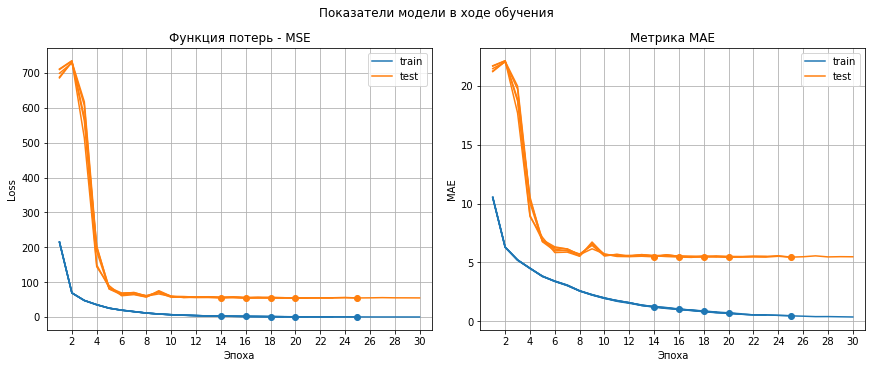

In [35]:
# строим графики
plot_train_results(results);

В начале обучения потери и *MAE* быстро уменьшаются. Чтобы лучше рассмотреть динамику изменения показателей в ходе обучения модели, надо увеличить масштаб по вертикали на графиках.

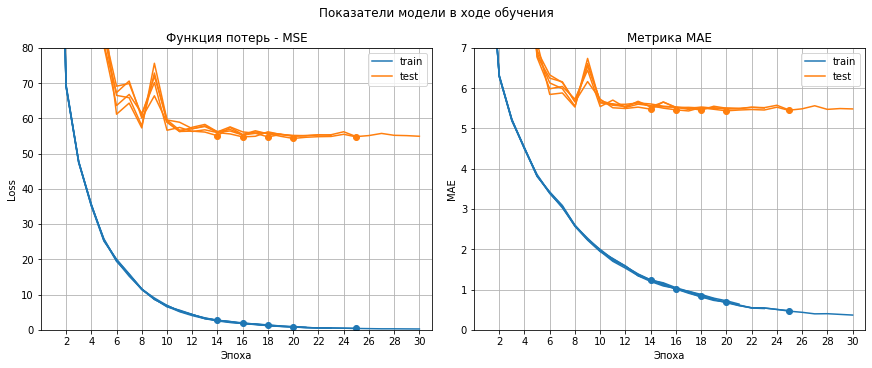

In [36]:
# опять строим графики
_, axes = plot_train_results(results)

# задаём масштаб
axes[0].set_ylim((0, 80))
axes[1].set_ylim((0, 7));

Оба графика показывают, что и *MSE*, и *MAE* на тестовой выборке всегда заметно больше, чем на обучающей. Значит, модель переобучается. Это естественно, т.к. в бэкбоне модели ResNet более 23 миллионов параметров, а в обучающей выборке всего 5694 RGB-изображения размером 224×224 пикселя, т.е. всего 224×224×3×5694 ≈ 857 млн чисел, что лишь в ≈36 раз больше.

Тем не менее, в ходе обучения модели целевая метрика *MAE* на тестовой выборке уменьшается и достигает к концу обучения, когда перестаёт уменьшаться функция потерь на тестовой выборке, значения менее 5.5.

Все 5 кривых для различных запусков кода обучения модели лежат близко друг к другу. Таким образом, фиксация случайного состояния при инициализации и обучении модели обеспечивает достаточную воспроизводимость, что позволяет сравнивать результаты обучения модели при подборе её гиперпараметров.

### Оценка качества модели

Оценим итоговое качество построенной модели на тестовой выборке метрикой *MAE*.

Выведем значения *MAE*, полученные при 5 запусках обучения модели на сервере с GPU.

In [37]:
# список значений MAE не тестовой выборке
# для 5 запусков обучения модели
mae_list = []

# заполняем список
for df in results:
    best = best_epoch_result(df)
    mae_list.append(best['val_metric'].values)

# преобразуем список в датафрейм
mae_df = pd.DataFrame(mae_list, columns=['MAE']).rename_axis('run')
mae_df

,MAE
run,
0,5.4529
1,5.4624
2,5.4378
3,5.4794
4,5.4539


Хотя 5 значений — это мало, чтобы получить точные оценки статистик, рассчитаем среднее значение, стандартное отклонение и доверительный интервал.

In [38]:
# среднее значение
mae_mean = mae_df['MAE'].mean()

# стандартное отклонение
mae_std = mae_df['MAE'].std()

# 99% доверительный интервал
confidence_interval_99 = lambda x: st.t.interval(0.99, x.count()-1, x.mean(), x.sem())
mae_conf_99 = confidence_interval_99(mae_df['MAE'])

print('Метрика MAE на тестовой выборке за {} запусков кода:\n'
      ' среднее значение: {:.3f}\n'
      ' стандартное отклонение: {:.3f}\n'
      ' 99% доверительный интервал: ({:.3f}, {:.3f})'.format(
      len(mae_df), mae_mean, mae_std, *mae_conf_99))

Метрика MAE на тестовой выборке за 5 запусков кода:
 среднее значение: 5.457
 стандартное отклонение: 0.015
 99% доверительный интервал: (5.426, 5.489)


Таким образом, значение метрики *MAE* на тестовой выборке, т.е. средняя абсолютная ошибка определения построенной моделью возраста человека на фотографии из тестовой выборки, получается **менее 5.5**, что является отличным результатом, т.к. не только удовлетворяет заданному требованию *MAE* < 8, но к тому же лишь ненамного превышает наилучшее значение 5.4, полученное в [статье о датасете](https://inria.hal.science/hal-01677892/document).

### Проверка на адекватность

Для проверки модели на адекватность сравним её с дамми-моделью `DummyRegressor`, которая всегда предсказывает константу — среднее значение целевого признака в обучающей выборке. В данном случае модель всегда предсказывает, что возраст человека на фото равен 31.2 года.

Модель можно считать адекватной, если точность её предсказаний на тестовой выборке существенно лучше, чем у дамми-модели.

In [39]:
# формируем обучающую и тестовую выборки для дамми-модели: 
# разделяем целевой признак
y_train, y_test = train_test_split(
    labels_df['real_age'], 
    test_size=0.25,
    random_state=RANDOM_STATE,
)
# пустые массивы входных признаков для дамми-модели
X_train = np.empty_like(y_train)
X_test = np.empty_like(y_test)

# инициализируем модель
dummy_model = DummyRegressor(strategy='mean')
print(f'Предсказание дамми-модели: {y_train.mean():.1f} лет')

# обучаем модель на обучающей выборке
dummy_model.fit(X_train, y_train)

# делаем предсказания на тестовой выборке
y_pred_dummy = dummy_model.predict(X_test)

# считаем метрику на тестовой выборке
dummy_mae = mean_absolute_error(y_test, y_pred_dummy)

print(f'Метрика MAE дамми-модели на тестовой выборке: {dummy_mae:.2f}')

Предсказание дамми-модели: 31.2 лет
Метрика MAE дамми-модели на тестовой выборке: 13.24


Дамми-модель показала намного худшую точность предсказаний. Значит, построенная нейронная сеть хорошо предсказывает возраст человека по фотографии.

### Выводы

Проведён анализ обученной модели, предназначенной для определения возраста человека по фотографии — свёрточной нейронной сети на базе бэкбона модели `ResNet50`. 
- Исходные данные для анализа — текстовый вывод метода `model.fit()` для 5 запусков обучения модели на сервере с GPU.
- Анализ динамики изменения функции потерь MSE и целевой метрики MAE от номера эпохи при обучении модели показал, что модель сильно переобучается. Это естественно, т.к. в бэкбоне модели ResNet 50 свёрточных слоёв и более 23 миллионов параметров, а нейронные сети с большим числом слоёв склонны к переобучению.
- Анализ воспроизводимости процесса обучения модели показал, что фиксация случайного состояния при инициализации и обучении модели обеспечивает достаточную воспроизводимость, позволяя сравнивать результаты обучения модели при подборе её гиперпараметров.
- Несмотря на переобучение, в ходе обучения модели целевая метрика *MAE* на тестовой выборке уменьшается, и к концу обучения, когда перестаёт уменьшаться функция потерь на тестовой выборке, выходит на плато.
- Итоговое значение метрики *MAE* на тестовой выборке, т.е. средняя абсолютная ошибка определения возраста человека на фотографии из тестовой выборки, получается **менее 5.5**, что является отличным результатом, т.к. не только удовлетворяет заданному требованию *MAE* < 8, но и лишь ненамного превышает наилучшее значение 5.4, полученное в [статье о датасете](https://inria.hal.science/hal-01677892/document).
- Сравнение точности предсказаний возраста человека по фотографии для построенной нейросети и дамми-модели, всегда предсказывающей возраст равным среднему значению в обучающей выборке, показало, что предсказания нейросети более чем адекватны: *MAE* предсказаний дамми-модели в 2.4 раза больше.

## Общий вывод

1. В проекте была поставлена **задача**: построить модель, которая по фотографии определит возраст человека.
    - Требования к модели: Значение метрики *MAE* (Mean Absolute Error — средняя абсолютная ошибка) на тестовой выборке должно быть не больше 8.

2. **Исходный датасет** [APPA-REAL](https://chalearnlap.cvc.uab.es/dataset/26/description/) содержит 7591 изображение, а также таблицу с именами файлов изображений и значением целевого признака — возраста человека на фото.

3. **Исследовательский анализ данных** показал:
    - Отсутствие проблем в данных — пропусков, дубликатов, несуществующих файлов и т.д.
    - Все изображения в датасете имеют формат JPEG и представлены в цветовой модели RGB, но не все имеют одинаковый размер. Подавляющее большинство изображений — квадратные, половина всех изображений имеет размеры от 220 до 632 пикселей. 
    - В датасете представлены фотографии людей различных рас и национальностей, явно полученные из разных открытых источников.
    - Распределения людей на фотографиях в датасете по возрасту в целом адекватно отражает распределение людей по возрасту в популяции, за исключением некоторых особенностей, вероятно обусловленных методикой сбора данных при составлении датасета.

4. Для решения задачи определения по фотографии возраста человека построена **модель — свёрточная нейронная сеть**. Обучение модели на обучающей выборке из предоставленного датасета выполнено на сервере с GPU.
    - Подготовка данных для обучения модели выполнена с использованием загрузчика данных `ImageDataGenerator`. 
        - Все изображения приведены к размеру 224×224 пикселя, как в датасете ImageNet.
        - Поскольку изображения в датасете уже центрированы и масштабированы, из дополнительных аугментаций в обучающей выборке добавлено только отражение по горизонтали.
    - Структура построенной нейронной сети: 
        - Бэкбон модели `ResNet50`, предобученный на датасете ImageNet;
        - Слой `GlobalAveragePooling2D`, усредняющий карты признаков (feature maps);
        - Полносвязный слой с одним нейроном и функцией активации `ReLU` для получения предсказания — возраста человека на фото. Инициализация нейрона выполнена с заданием фиксированного случайного состояния.
    - Обучение модели проведено путём минимизации функции потерь *MSE* (Mean Squared Error). Процесс обучения останавливался, если функция потерь на тестовой выборке не уменьшалась в течение 5 эпох подряд. Для достижения максимальной воспроизводимости результатов обучения модели фиксировалось случайное состояние везде, где только можно.

5. **Анализ обученной модели** показал:
    - Построенная нейронная сеть хорошо предсказывает возраст человека по фотографии: средняя абсолютная ошибка определения возраста человека на фотографии из тестовой выборки составила **менее 5.5**.
    - Модель сильно переобучается, но это не приводит к снижению точности предсказаний на тестовой выборке.
    - Фиксация случайного состояния при инициализации и обучении модели обеспечивает достаточную воспроизводимость, позволяя сравнивать результаты обучения модели при подборе её гиперпараметров.
    
6. **Выводы для бизнеса**:
    - Построенную нейросеть для определения возраста по фото можно использовать в сочетании с системой компьютерного зрения, обеспечивающей фотофиксацию лица покупателя в прикассовой зоне, чтобы анализировать покупки и предлагать товары, которые могут заинтересовать покупателей определённой возрастной группы. Предсказание возраста позволяет произвольно выделять возрастные группы для анализа, не меняя при этом используемую модель.
    - Использование построенной нейросети для определения возраста покупателей при продаже алкоголя не рекомендуется по причине недостаточной точности модели (средняя ошибка определения возраста 5.5 лет). Для этой задачи лучше подойдёт модель бинарной классификации (старше или младше 18 лет человек на фото), настроенная на максимизацию полноты выявления лиц младше 18 лет.
    - Чтобы повысить точность определения возраста, рекомендуется для обучения нейросети собрать репрезентативный датасет с фотографиями жителей местности, в которой её предполагается применять. Один из способов сделать это — фотофиксация покупателя при оплате на кассе при предъявлении им карты покупателя, привязанной к профилю, в котором указана дата рождения.